# import funcs

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate

import xarray as xr
import dask.array as da
from dask.distributed import Client

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches # for creating legend
import matplotlib.dates as mdates # converts datetime64 to datetime

import cartopy
import cartopy.crs as ccrs # for plotting
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point # for wrapping map fully - avoiding white line on 0 deg
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.dates as mdates # converts datetime64 to datetime
import matplotlib.gridspec as gridspec # to create grid-shaped combos of axes
from mpl_toolkits import mplot3d # 3d plotting tool
import cmocean # for nice oceanography colour pallettes

#import argopy
#from argopy import DataFetcher as ArgoDataFetcher # to load Argo ds directly

import os # for finding files

import gsw # for conversion functions

from tqdm.notebook import tqdm_notebook as tqdm
import glob # for downloading data
import sys # for path to functions

import seaborn as sns

sns.set(#font='Franklin Gothic Book',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'w', 
                            # '#aeaeae',
         'axes.grid': False,
         'axes.labelcolor': 'k',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1)
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["axes.titlesize"] = 22
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["font.size"] = 18
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
mpl.rcParams["ytick.labelright"] = False

from warnings import filterwarnings as fw
fw('ignore')

# import my own funcs
import sys
sys.path.append('/home/theospira/notebooks/projects/01-WW_climatology/functions')
from plot_formatting import circular_boundary,plot_nice_box
from inspection_funcs import boxplot

import importlib
#importlib.reload(sys.modules['inspection_plot'])

In [7]:
from matplotlib.dates import AutoDateLocator

sys.path.append('/home/theospira/notebooks/projects/03-WW-timeseries/funcs')
from plotting import *
from computations import *
from import_data import *

## funcs

In [3]:
from plot_formatting import plot_gridlines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def ww_classif_bar_chart(ds, ax=None, w=1, ret_ax=0, plot_percentage_distrib=False, c='#bebebe'):
    """
    Create a bar chart showing the absolute quantity of hydrographic profiles coloured by WW classification.

    Parameters:
    -----------
    ds : xarray.Dataset
        The dataset containing the hydrographic profile data.
    ax : matplotlib.axes.Axes, optional
        The matplotlib axes to plot on. If not provided, a new figure and axes will be created.
    w : float, optional
        The width of the bars.
    ret_ax : int, optional
        If set to 1, the function returns the axis object. Default is 0.
    """
    
    tmp_ww = ds[['ww_ml','ww_ss','uncat','net']]
    tmp_ww = tmp_ww.sum(('lat','lon'))
    
    # Calculate percentages
    pct_ml   = (tmp_ww.ww_ml / tmp_ww.net) * 100
    pct_ss   = (tmp_ww.ww_ss / tmp_ww.net) * 100
    pct_uncl = (tmp_ww.uncat / tmp_ww.net) * 100
    
    # Plotting
    
    # Define the colors for ML WW, SS WW, and unclassified
    c = ['#377eb8', '#ff7f00', '#bebebe']
    # Create a ListedColormap with the specified colors
    cmap = ListedColormap(c)
    
    if ax is None:
        plt.figure(figsize=(15, 8))
        ax = plt.gca()
    
    # define x axis
    #x_ax = tmp_ww.time
    x_ax = np.arange(0,tmp_ww.time.size,1)
    kwargs=dict(x=x_ax, width=1, edgecolor=None, linewidth=0.1, align='edge')
    
    # plot data
    ax.bar(**kwargs, height=pct_ml, label='ML WW', color=c[0],)
    ax.bar(**kwargs, height=pct_ss, bottom=pct_ml, label='SS WW', color=c[1],)
    ax.bar(**kwargs, height=pct_uncl, bottom=pct_ml + pct_ss, label='Unclassified', color=c[2],)
    
    xtix = np.arange(0,205,12)
    ax.set_xticks(xtix[1::2],)
    ax.set_xlim(0,x_ax[-1]+1)
    ax.xaxis.set_minor_locator(plt.FixedLocator(xtix[::2]))
    ax.set_xticklabels(pd.date_range(str(ds.time.dt.year.min().data)+'-01-01', '2022-02-01', freq='1M'
                                    )[xtix[1::2]].strftime('%Y'))
    
    if plot_percentage_distrib:
        # Plot overall percentage distribution on another axis
        # here, oa stands for overall
        oa_pr  = n_pr.sum()
        
        oa_ml  = ww_ml.sum() / oa_pr * 100
        oa_ss  = ww_ss.sum() / oa_pr * 100
        oa_unc = unclassified.sum() / oa_pr * 100
        # Plot overall percentage distribution on the third subplot
        pcnt_ax.bar(['Overall'], [oa_ml], label='ML WW', color=c[0], lw=0, )
        pcnt_ax.bar(['Overall'], [oa_ss], bottom=[oa_ml], label='SS WW', color=c[1], lw=0, )
        pcnt_ax.bar(['Overall'], [oa_unc], bottom=[oa_ml + oa_ss], label='Unclassified', color=c[2], lw=0, )

    
    if ret_ax:
        return ax,cmap
    else:
        return cmap

def dsource_classif_bar_chart(ds, ax=None, w=1, ret_ax=0):
    """
    Create a bar chart showing the absolute quantity of hydrographic profiles coloured by data source.

    Parameters:
    -----------
    ds : xarray.Dataset
        The dataset containing the hydrographic profile data.
    ax : matplotlib.axes.Axes, optional
        The matplotlib axes to plot on. If not provided, a new figure and axes will be created.
    w : float, optional
        The width of the bars.
    ret_ax : int, optional
        If set to 1, the function returns the axis object. Default is 0.
    """

    t_bins = pd.date_range(str(ds.time.dt.year.min().data-1)+'-12-31', '2022-01-01', freq='1M')
    
    tmp_dsr = ds[['argo','meop','ctd','gldr','net',]]
    tmp_dsr = tmp_dsr.sum(('lat','lon'))
    
    # Calculate percentages
    pct_arg  = tmp_dsr['argo']# / tmp_dsr.net) * 100
    pct_mp   = tmp_dsr.meop  #/ tmp_dsr.net) * 100
    pct_ctd  = tmp_dsr.ctd   #/ tmp_dsr.net) * 100
    pct_gldr = tmp_dsr.gldr  #/ tmp_dsr.net) * 100
    
    # Plotting
    
    # Define the colors for argo, meop, ctd, glider
    c = ['#9e0142', '#86cfa5', '#f98e52', '#ffffbe',]
    
    # Create a ListedColormap with the specified colors
    cmap = ListedColormap(c)
    
    if ax is None:
        plt.figure(figsize=(15, 8))
        ax = plt.gca()
    
    # define x axis
    #x_ax = tmp_ww.time
    x_ax = np.arange(0,ds.time.size,1)
    kwargs=dict(x=x_ax, width=1, edgecolor=None, linewidth=0.1, align='edge')
    
    # plot data
    ax.bar(**kwargs, height=pct_arg, label='Argo', color=c[0],)
    ax.bar(**kwargs, height=pct_mp, bottom=pct_arg, label='MEOP', color=c[1],)
    ax.bar(**kwargs, height=pct_ctd, bottom=pct_arg + pct_mp, label='CTD', color=c[2],)
    ax.bar(**kwargs, height=pct_gldr, bottom=pct_arg + pct_mp + pct_ctd, label='Glider', color=c[3],)
    
    xtix = np.arange(0,205,12)
    ax.set_xticks(xtix[1::2],)
    ax.set_xlim(0,x_ax[-1]+1)
    ax.xaxis.set_minor_locator(plt.FixedLocator(xtix[::2]))
    ax.set_xticklabels(pd.date_range(str(ds.time.dt.year.min().data)+'-01-01', '2022-02-01', freq='1M'
                                    )[xtix[1::2]].strftime('%Y'))
    return cmap

def zones_percentage_bar_chart(ds, zones, ax=None, ret_ax=0, freq='1M', c = ['#332288', '#117733', '#DDCC77', '#CC6677', '#882255']):
    """
    Create a bar chart showing the percentage of ML WW profiles, SS WW profiles, and unclassified profiles per month.

    Parameters:
    -----------
    ds : xarray.Dataset
        The dataset containing the hydrographic profile data.

    freq : str, optional
        The frequency of time bins (e.g., '1M' for monthly). Default is '1M'.
    """
    
    t_bins = pd.date_range(str(ds.time.dt.year.min().data-1)+'-12-31', '2022-01-01', freq='1M')
    
    net = ds.net.sum('lat')
    net_tot = ds.net.sum(('lat','lon'))
    
    # create empty arrays
    zones_arr = np.zeros((net.time.size,len(zones),))
    
    # Calculate percentages
    for j,z in enumerate(zones):
        if z[-1] < z[0]:
            z0,z1=z[0]%360,z[-1]%360
            zones_arr[:,j] = net.where((net.lon%360>z0) & (net.lon%360<z1)).sum('lon').data # / net_tot.data
        else:
            z0,z1=z[0],z[-1]
            zones_arr[:,j] = net.where((net.lon>z0) & (net.lon<z1)).sum('lon').data # / net_tot.data
    
    # Calculate percentages
    z_tot = np.full_like(zones_arr,np.nan)
    z_tot = np.sum(zones_arr,axis=1)[:, np.newaxis] + np.zeros_like(zones_arr)
    zones_pct = zones_arr / z_tot * 100
    
    # Plotting
    # Define the colors for ML WW, SS WW, and unclassified
    c = ['#332288', '#117733', '#DDCC77', '#CC6677', '#882255']
    # Create a ListedColormap with the specified colors
    cmap = ListedColormap(c)
    
    if ax is None:
        plt.figure(figsize=(15, 8))
        ax = plt.gca()
    
    # define x axis
    #x_ax = tmp_ww.time
    x_ax = np.arange(0,net.time.size,1)
    kwargs=dict(x=x_ax, width=1, edgecolor=None, linewidth=0.1, align='edge')
    
    # plot data
    bottom = np.full_like(zones_arr,0)[:,0]
    for i in range(len(zones)):
        ax.bar(**kwargs, height=zones_pct[:,i], bottom=bottom, color=c[i],)
        bottom+=zones_pct[:,i]
    
    xtix = np.arange(0,205,12)
    ax.set_xticks(xtix[1::2],)
    ax.set_xlim(0,x_ax[-1]+1)
    ax.xaxis.set_minor_locator(plt.FixedLocator(xtix[::2]))
    ax.set_xticklabels(pd.date_range(str(ds.time.dt.year.min().data)+'-01-01', '2022-02-01', freq='1M'
                                    )[xtix[1::2]].strftime('%Y'))
    
    if ret_ax:
        return ax
    else:
        return ListedColormap(c)

def plot_SO_zones_map(ax,zones,c = ['#332288', '#117733', '#DDCC77', '#CC6677', '#882255'],lw=5):

    # colour SO by defined c
    y1,y2=-80,-51.5
    kwargs = dict(y1=y1,y2=y2,lw=lw,zorder=10,)
    for i,z in enumerate(zones):
        if z[-1] < z[0]:
            x1,x2=(z[-1]-0.5)%360,(z[0]+0.5)%360
            plot_nice_box(ax=ax,x1=x1,x2=x2,c=c[i],**kwargs)
    
            # Fill between the curves        
            ax.add_patch(mpatches.Rectangle(xy=[x1, y1], width=x2-x1, height=y2-y1,
                            facecolor=c[i],alpha=0.2,transform=crs))
        
        else:
            x1,x2=z[-1]-0.5,z[0]+0.5
            plot_nice_box(ax=ax,x1=x1,x2=x2,c=c[i],**kwargs)
            ax.add_patch(mpatches.Rectangle(xy=[x1, y1], width=x2-x1, height=y2-y1,
                            facecolor=c[i],alpha=0.2,transform=crs))

    return c

# load data

In [11]:
d_path = '/home/theospira/notebooks/projects/03-WW-timeseries/data/hydrographic_profiles/'
ds_grid = xr.open_dataset(d_path+'gridded-timeseries-ww-recalc1.nc')

ds = xr.open_dataset(d_path+'hydrographic_profiles_1.nc')
# add masked array
ds['msk'] = xr.DataArray(np.load(d_path+'masked_vars/masked_arr.npy'),dims={'n_prof':ds.n_prof})
ds = ds.isel(n_prof=np.where(ds.msk!=1)[0])
ds = ds.isel(n_prof=np.where(ds.time>np.datetime64('2004-12-31'))[0])

# open dataset with sum of variables
ds_count = xr.open_dataset('/home/theospira/notebooks/projects/03-WW-timeseries/src/ts_grid_of_total_no_ww_and_dsource.nc')
ds_count['net']   = ds_count.ww_ss + ds_count.ww_ml + ds_count.uncat
ds_count['net']   = ds_count.net.where(ds_count.net>0,np.nan)
ds_count['ww_ct'] = ds_grid.ww_ct.copy()
ds_count = mask_data(ds_count)

contains ww_ct


# plot

In [9]:
si = load_sea_ice()
si = si.sel(lat=slice(-80,-52)).sel(time=slice('2005-01-01','2022-01-01'))
si = calc_mean_var(si,'sia')
si = calc_mean_var(si,'sic')
# compute sia_anm
si['sia_anm'] = si.sia - si.sia_mn

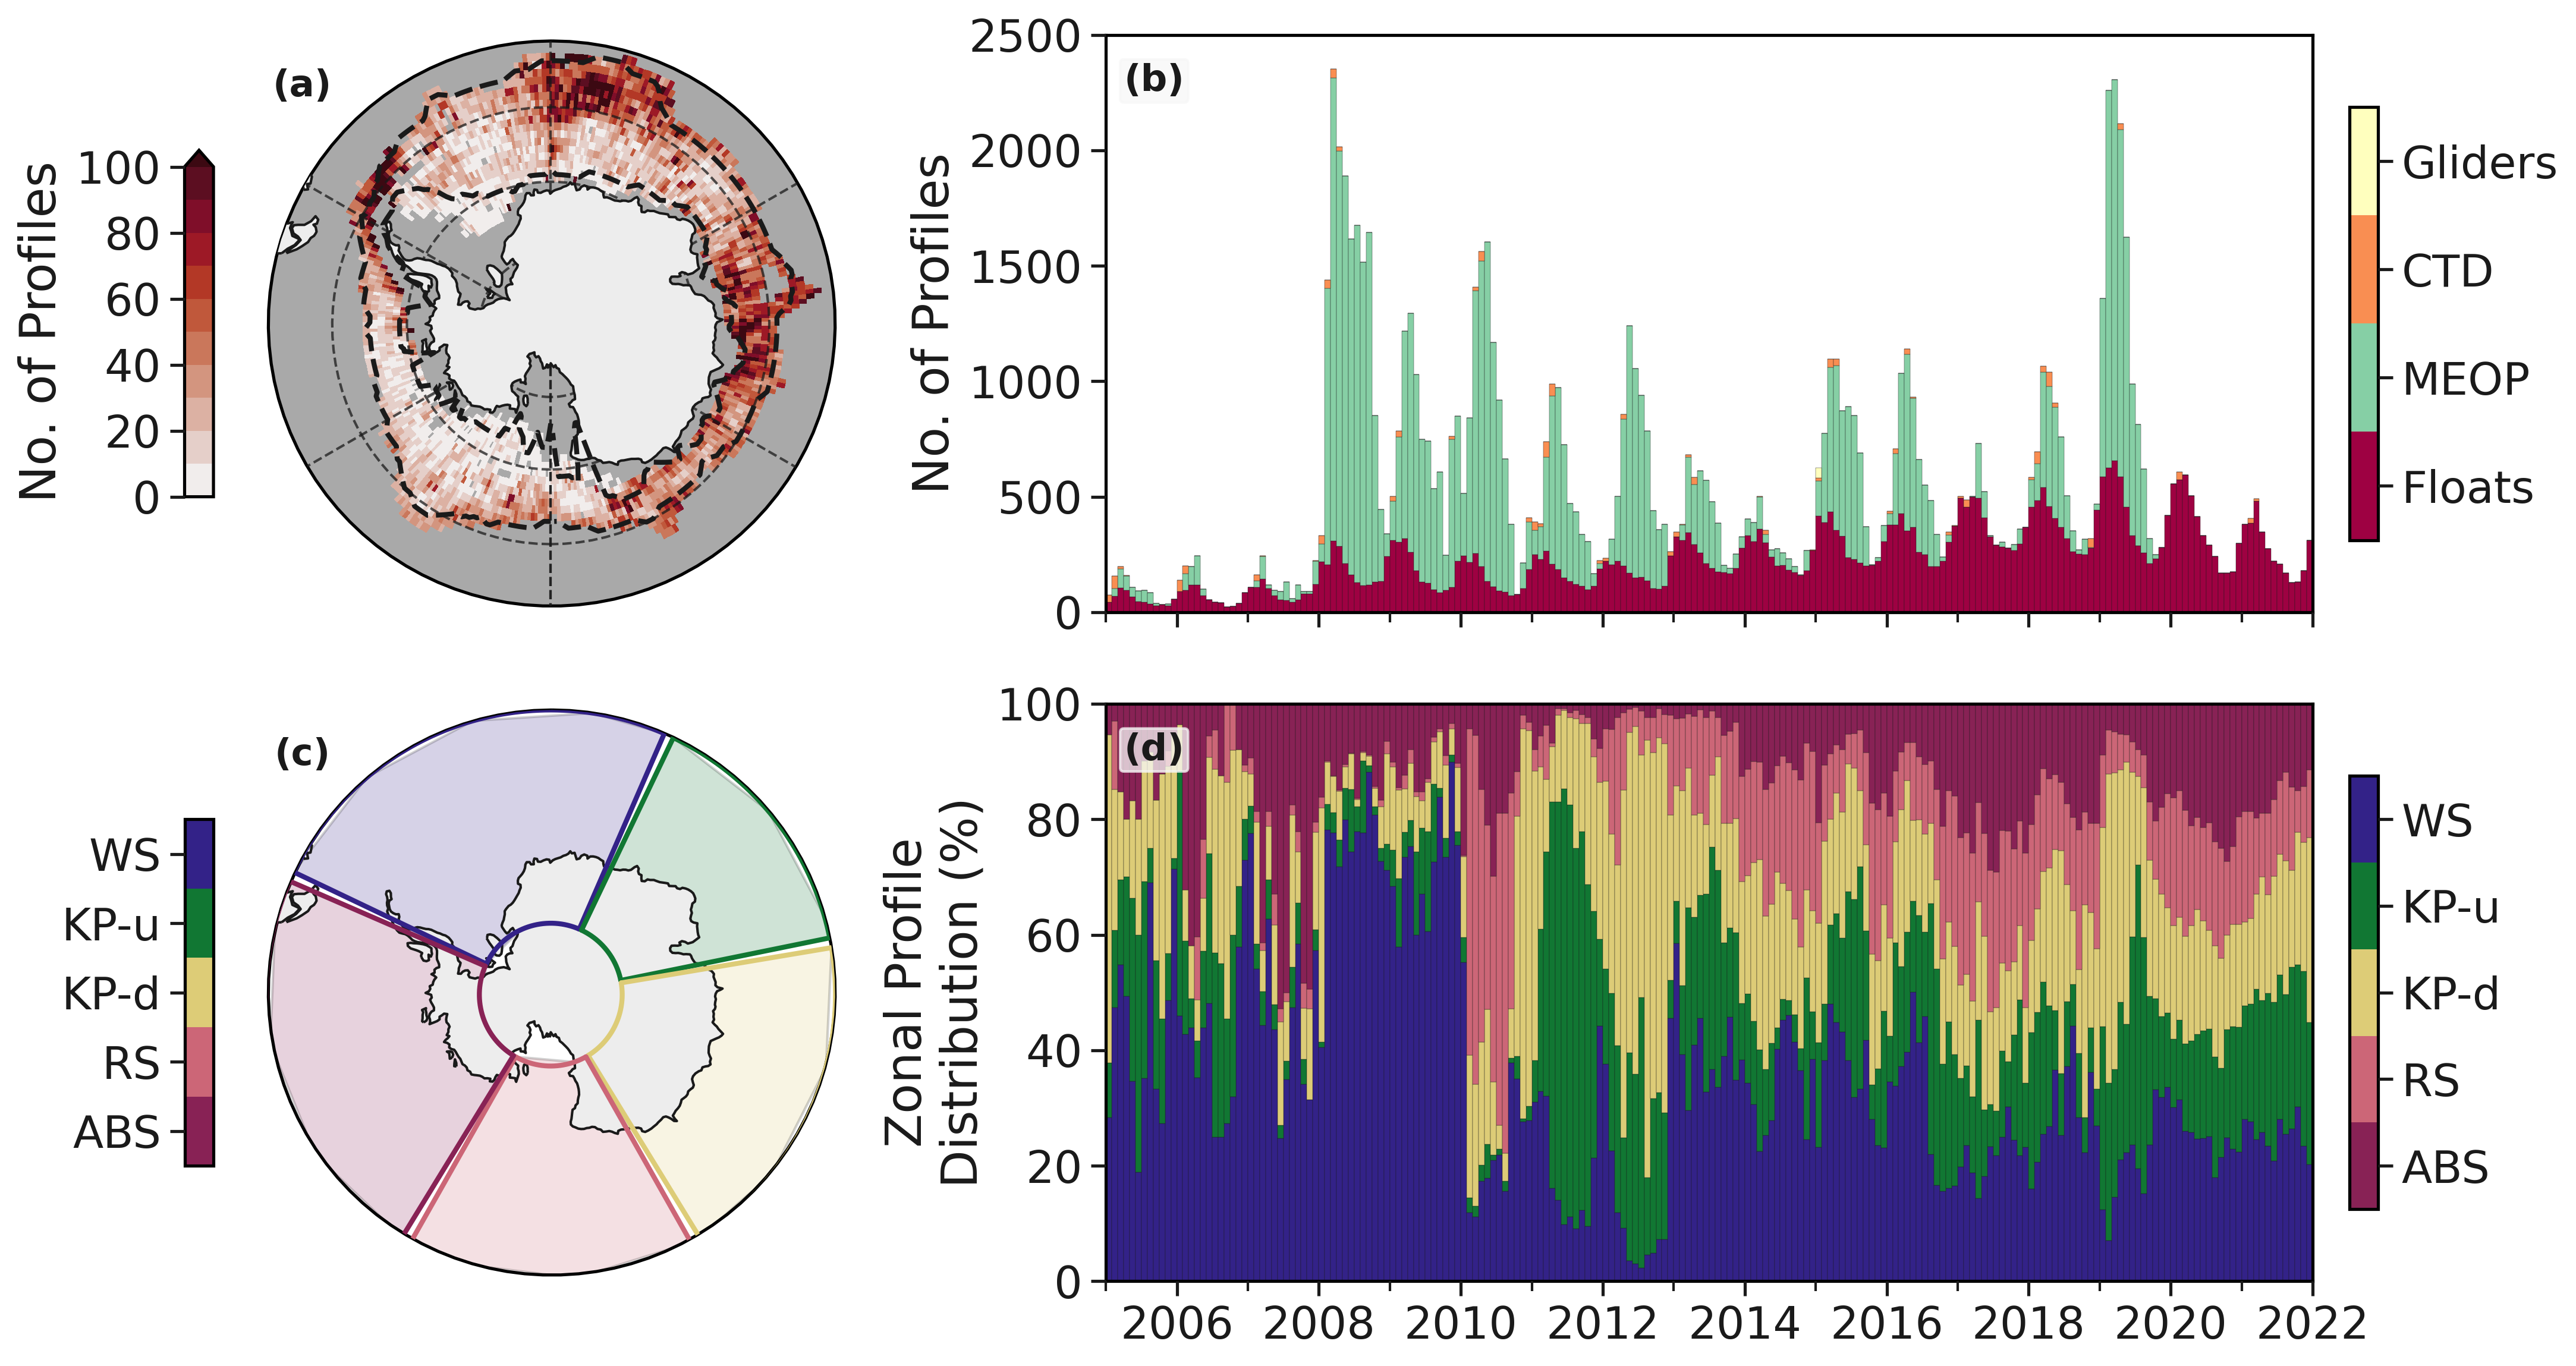

In [10]:
r,c=2,2
fig = plt.figure(figsize=(15, 4*r), dpi=300)
gs  = gridspec.GridSpec(r, c, figure=fig, width_ratios=[4/12, 8/12],)
gs2 = gridspec.GridSpec(r, c+2, figure=fig, width_ratios=[0.2,0.8,0.2,3],)
crs = ccrs.PlateCarree()

# Create subplots for the first row (excluding the colorbar space)
ax = []

# Create subplots for the first column
ax.append(fig.add_subplot(gs[0, 0],projection=ccrs.SouthPolarStereo()))
ax.append(fig.add_subplot(gs[1, 0],projection=ccrs.SouthPolarStereo()))

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent([0,360,-90,-51.5],crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
plot_gridlines(ax=ax[0],color='k',)    
ax[0].set_facecolor('darkgrey')

# kwargs for circumpolar plots
kwargs = dict(x='lon',transform=crs,)
cb_kw = {'aspect':12,'shrink':0.6,'location':'left','pad':0.075,}

n_prof = ds_count.net.sum('time')
n_prof = n_prof.where(n_prof>0)
cb = n_prof.plot(**kwargs,ax=ax[0],cmap='cmo.amp',vmin=0,vmax=100,levels=11,
                 cbar_kwargs={**cb_kw,'label':'No. of Profiles','ticks':np.arange(0,101,20),}
                ).colorbar
cb.ax.minorticks_off()

wrap_smth_var(np.abs(si.sic_mn.sel(time=si.sia_mn.sum(('lat','lon')).idxmin().data # min mean sea ice area
                                   )-0.15).idxmin('lat')).plot(ax=ax[0],ls='--',c='k',lw=2,zorder=10,**kwargs,)
wrap_smth_var(np.abs(si.sic_mn.sel(time=si.sia_mn.sum(('lat','lon')).idxmax().data # max mean sea ice area
                                  )-0.15).idxmin('lat')).plot(ax=ax[0],ls='--',c='k',lw=2,zorder=10,**kwargs,)
ax[0].set_title('')

# zones circumpolar plot
sectors = ["WS","KP-u","KP-d","RS","ABS",]
zones = [np.arange(-65,25),    # DP + WG
         np.arange(25,80),     # upstream of KP
         np.arange(80,150),    # downstream of KP
         np.concatenate([np.arange(150,180),np.arange(-180,-149)]), # ross sea
         np.arange(-149,-65),]  # amundsen and bellinghausen sea
c = plot_SO_zones_map(ax[1],zones,lw=2)
cb = plt.colorbar(plt.cm.ScalarMappable(cmap=ListedColormap(c)), ax=ax[1], **cb_kw)
# set cbar ticks
x = len(zones)
x_space = 1/x
cb.set_ticks(np.arange(x_space/2,1,x_space))
cb.set_ticklabels(sectors)
cb.ax.minorticks_off()
cb.ax.invert_yaxis()

# plot bar chars
for j in range(r):
    ax.append(fig.add_subplot(gs[j, 1]))

# colorbar args
cbar_kw = dict(shrink=0.75, aspect=15, pad=0.025) 

# data source classification timeseries 
cmap = dsource_classif_bar_chart(ds_count,ax[2])
ax[2].set_ylim(0,2500)
ax[2].set_ylabel('No. of Profiles')

cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax[2], **cbar_kw)
x = 4
x_space = 1/x
cb.set_ticks(np.arange(x_space/2,1,x_space))
cb.set_ticklabels(['Floats', 'MEOP', 'CTD', 'Gliders'])
cb.ax.minorticks_off()

## SO Zones timeseries
cmap = zones_percentage_bar_chart(ds_count,zones=zones,ax=ax[3])
ax[3].set_ylabel('Zonal Profile\nDistribution (%)')

# cbar for percentage
cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax[3], **cbar_kw)
# set cbar ticks
x = len(zones)
x_space = 1/x
cb.set_ticks(np.arange(x_space/2,1,x_space))
cb.set_ticklabels(sectors)
cb.ax.minorticks_off()
cb.ax.invert_yaxis()

for a in ax[r:]:
    a.set_xlim(0,204)
for a in ax[r:-1]:
    a.set_xticklabels('')

# label first column
a_y = 0.92 # y pos'n
for j,a in zip([0,2],ax[:2]):
    fig_labels(a_x=0.06,a_y=a_y,ax=a,j=j,add_bbox=0)
# label second column
for j,a in enumerate(ax[2:]):
    j = j*2 + 1
    fig_labels(a_x=0.04,a_y=a_y,ax=a,j=j,)
fig.tight_layout()

## some stats

In [18]:
for i in range(1,5,1):
    print(i,(ds.dsource==i).sum().data)

1 55412
2 1735
3 2003
4 134044


In [79]:
ds.n_prof.count().data

array(193194)

In [20]:
print('WW_ML: ', (ds.ww_type==1).sum().data)
print('WW_SS: ', (ds.ww_type==2).sum().data)
print('total profs: ', ds.n_prof.count().data)
print('# unclassified profs: ', (ds.n_prof.count()-(ds.ww_type.notnull()).sum()).data)

WW_ML:  88413
WW_SS:  66897
total profs:  193194
# unclassified profs:  37884


In [21]:
88413 + 66897 + 37884

193194

In [22]:
for i in range(1,5,1):
    print(i,(ds.dsource==i).sum().data)

1 55412
2 1735
3 2003
4 134044


In [59]:
chk = xr.open_dataset(d_path+'hydrographic_profiles_1.nc')
print('total profiles from 2005 onwards (unmasked): ',np.where(chk.time>=np.datetime64('2005-01-01'))[0].size)
del(chk)

total profiles from 2005 onwards (unmasked):  589312


In [8]:
from gridding import *
from smoothing_and_interp import *
from plot_formatting import plot_gridlines